Rudy LEVET

Nathan HUMEAU

Huan Jie YEN

Amar KACI


#Rapport de SAE

## Introduction

Étudiants en dernière année de BUT Informatique et, dans le cadre de notre SAE (Situation d'apprentissage et d'entreprise),  nous avons pour objectif de classifier le sexe et l’âge des individus à partir du jeu de données UTKFace. Ce dataset regroupe un large éventail d’images de visages, présentant une diversité de poses, de conditions d’éclairage, d’ethnies et d’âges, allant de 0 à 116 ans.

Ce rapport a pour but de présenter les démarches entreprises pour chaque modèle que nous avons implémenté ainsi que leur résultats. Une description plus détaillée de chaque modèle est disponible dans les fichiers qui leur sont dédiés.



## I. Classification de Genre avec CNN

###1.1. Visualisation de la répartition des sexes

Dans un premier temps, nous souhaitons concevoir un modèle de classification du sexe à l’aide d’un réseau de neurones convolutifs (CNN).

Pour cela, nous commençons par analyser la répartition des données, afin de vérifier si le dataset est équilibré entre les classes "Homme" et "Femme".

En effet, un déséquilibre important pourrait introduire un biais lors de l’apprentissage du modèle, ce qui le rendrait plus performant pour la classe majoritaire, au détriment de l’autre.

Une visualisation sous forme d’histogramme permet ainsi de mettre en évidence d’éventuelles disparités, et d’envisager des solutions adaptées.

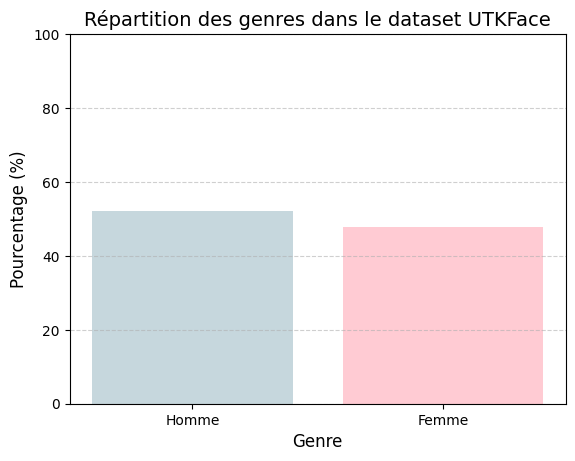

Le jeu de données présente une légère surreprésentation de la classe "Homme", avec environ 55 % des images, contre 45 % pour la classe "Femme".

Bien que cet écart ne soit pas particulièrement prononcé, il pourrait tout de même impacter les performances du modèle, notamment si celui-ci développe une tendance à privilégier la classe majoritaire.

Une attention particulière sera donc porté à l’évaluation des métriques de performance telles que la précision, le rappel et le F1-score, afin de s’assurer que le modèle reste équilibré et ne favorise pas une classe au détriment de l’autre.


###1.2. Traitement des images

Avant l’entraînement de notre modèle CNN, une phase de prétraitement des images est nécessaire. Celle-ci se déroule en plusieurs étapes :

- Parcours des fichiers du dataset

- Extraction du genre à partir du nom de fichier (chaque image étant nommée selon le format : âge_genre_ethnie_dateNaissance.jpg)

- Lecture de l’image à l’aide de bibliothèques adaptées

- Redimensionnement des images à une taille uniforme compatible avec le modèle

- Normalisation des valeurs de pixels : les valeurs, initialement comprises entre 0 et 255, sont divisées par 255.0 afin d’être ramenées dans une plage de [0, 1]

Le code ci-dessous a été utilisé pour le traitement des images :



```python
#TRAITEMENT DE L'IMAGE

def load_data(data_dir=DATA_DIR):
    X = [] #liste d'img après traitement convertit en NumPY
    y = [] #liste contenant les genres

    # Récup tts les img dans UTKFace
    file_names = os.listdir(data_dir)

    for file in file_names:
        # nom de fichier type "age_sexe_ethnie_dateNaiss.jpg"
        # On récupère le deuxième champ pour le genre
        # 0 => Homme, 1 => Femme
        parts = file.split("_")
        gender_str = parts[1]
        try:
            gender = int(gender_str)
        except:
            continue

        # lecture
        img_path = os.path.join(data_dir, file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # conversion en RGB (cv2 lit en BGR par défaut)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # redimension
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

        # Normalisation
        img = img.astype("float32") / 255.0

        X.append(img)
        y.append(gender)

    return np.array(X), np.array(y)

# Chargement des données
X, y = load_data(DATA_DIR)
```



### 1.3. Division du jeu de données

Afin d’évaluer correctement la capacité de généralisation de notre modèle, nous divisons le jeu de données en trois sous-ensembles distincts:

- Jeu d’entraînement (64 %) : Il s’agit de la portion principale du dataset, utilisée pour l’apprentissage du modèle. Plus le volume de données d’entraînement est important, plus le modèle est susceptible de bien généraliser.


On pourrait vouloir 80-90% pour l'entraînement, mais cela signifie moins de données pour la validation.

Or, sans validation, on ne pourrait pas mesurer correctement si le modèle est en train de sur-apprendre (overfitting).

- Jeu de validation 20% : Ce sous-ensemble permet d’ajuster les hyperparamètres (comme le taux d’apprentissage ou le nombre d’époques) et de surveiller l'apparition d’un éventuel surapprentissage (overfitting). Une part trop faible (5–10 %) pourrait limiter la précision des ajustements, tandis qu’une part trop importante (30–40 %) réduirait significativement la quantité de données disponibles pour l'entraînement.

Si on met trop peu de données ici (ex. 5-10%), les ajustements risquent d’être moins précis.
Si on met trop (ex. 30-40%), il reste trop peu de données pour entraîner le modèle.

- Jeu de test (test) 20% : Utilisé uniquement pour évaluer les performances finales du modèle sur des données qu’il n’a jamais vues. Il sert à estimer comment le modèle se comportera sur des nouvelles images dans un contexte réel.

Si l'on réparti peu de données dans le jeu de test (<10%), la mesure de performance sera peu fiable.

En revanche, s'il y a trop de données dans le jeu test (>30%), on réduit trop l’ensemble d'entraînement et le modèle de ne pas apprendre correctement.


Le schéma ci-dessous illustre la répartition adoptée dans ce modèle :


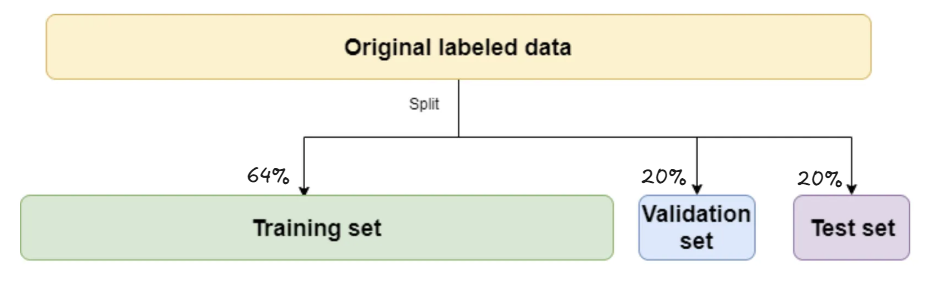

### 1.4 Implémentation et callbacks

Dans ce modèle, une phase de data augmentation est intégrée directement au début du modèle, via des transformations aléatoires appliquées sur les images d’entrée.

Ces transformations visent à augmenter la diversité des données vues par le modèle.

Ce modèle introduit une architecture structurée en quatre blocs convolutionnels successifs, avec un nombre de filtres croissant avec quatre couches contenant respectivement 16, 32, 64, et 128 filtres.

Chaque bloc convolutionnel est suivi d'un BatchNormalization.

Il intègre également une couche de Dropout après la couche dense.

Cette régularisation désactive aléatoirement 40% des neurones à chaque itération, ce qui réduit le risque de surapprentissage.

La couche dense finale du modèle contient 1 neurone avec Sigmoïde pour activation dans le cadre de la classificaiton de genre.

Le schéma ci-dessous représente l'architecture du modèle:

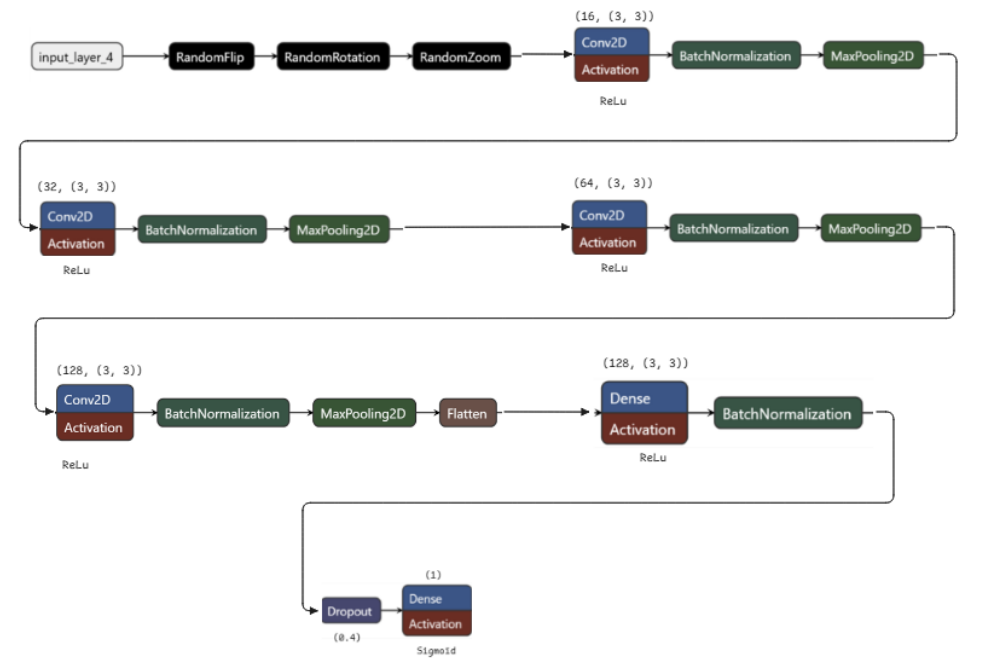

Par la suite, la régulation a été mis en place à l'aide de callbacks pour éviter le surapprentissage : EarlyStopping et ReduceLROnPlateau.

Le premier permet d'interrompre automatiquement l'entraînement si la performance sur l'ensemble de validation (ici mesurée par la val_loss) n'affiche aucune amélioration après 8 époques consécutives.

De plus, il restaure les poids du modèle correspondant à la meilleure époque observée.

Le second, ReduceLROnPlateau, ajuste dynamiquement le taux d’apprentissage en le réduisant d’un facteur de 0.5 si aucune amélioration de la val_loss n’est constatée après 3 époques, avec une limite minimale fixée à 1e-5.

L'entraînement a ensuite été lancé sur un maximum de 50 époques avec un batchsize de 32, en utilisant ces deux callbacks.



```python

# Callbacks: EarlyStopping + ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Surveille la val_loss
    factor=0.5,          # Divise le LR par 2
    patience=3,          # Après 3 époques sans amélioration
    min_lr=1e-5          # LR plancher
)


history_v2 = model_v2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,          # Nombre max d'époques
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)
```



### 1.5. Visualisations et interprétation des résultats

Ce modèle a aboutit aux résultats suivants :

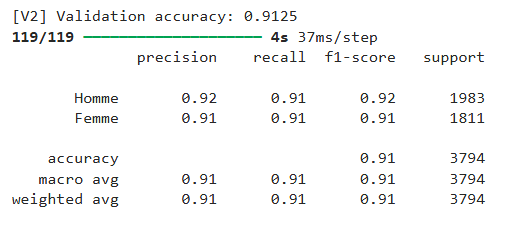

Ce modèle affiche des scores équilibrés entre les classes "Homme" et "Femme" :

En effet, cela est particulièrement visible au niveau des précisions des deux classes, proches et symétriques (entre 0,91 et 0,92), ce qui signifie que le modèle est aussi fiable pour prédire un homme que pour prédire une femme.




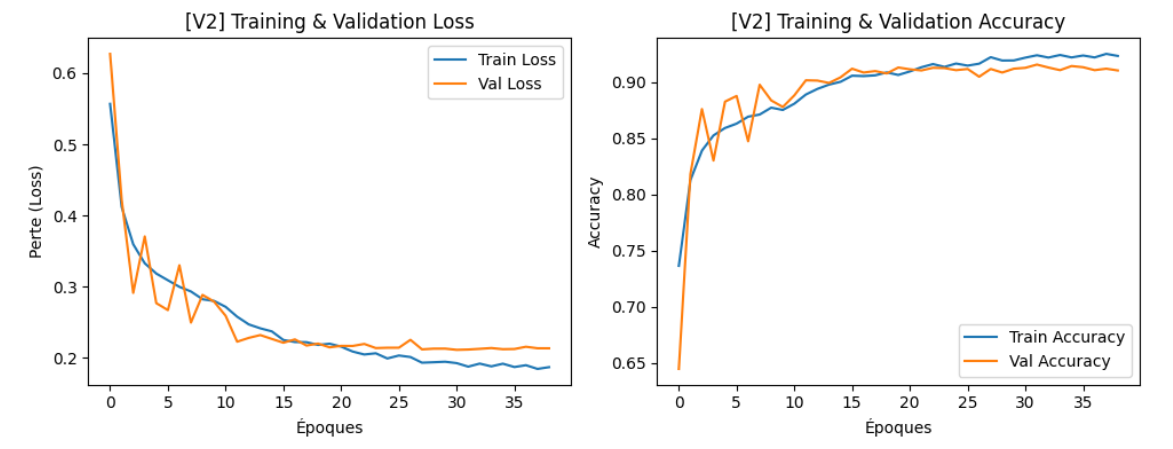

La fonction de perte d’entraînement diminue de manière régulière au fil des époques, sans oscillations notables, ce qui témoigne d’un apprentissage progressif et stable.

La loss de validation suit une tendance similaire, sans remontée brutale ni fluctuations importantes, ce qui suggère que le modèle ne souffre pas d'overfitting.

Du côté de la précision, les accuracy d’entraînement et de validation restent proches tout au long de l’entraînement, ce qui indique une bonne capacité de généralisation : le modèle apprend sans mémoriser excessivement les données d’entraînement.

Il est également intéressant de noter que l’accuracy de validation dépasse légèrement celle de l’entraînement à certaines époques.

Ce phénomène peut s’expliquer par l’effet du Dropout, qui désactive aléatoirement des neurones pendant l’entraînement, rendant le réseau temporairement moins performant, mais plus robuste sur des données inédites.



## II. Classification d’âge avec une Approche de Régression

Dans cette partie, en vue d’entraîner un modèle de régression capable d’estimer l’âge des individus à partir de leurs photos faciales, nous préparons dans un premier temps, les données du dataset UTKFace  

Contrairement à une tâche de classification binaire, comme la différenciation entre hommes et femmes, il s’agit ici d’une prédiction continue de l’âge. Ces valeurs continues seront ensuite regroupées en classes d’âges pour permettre l’évaluation du modèle.

Cependant, avant de passer à l’entraînement, nous analysons la répartition des âges au sein du dataset.


###2.1 Visualisation de la répartition des âges

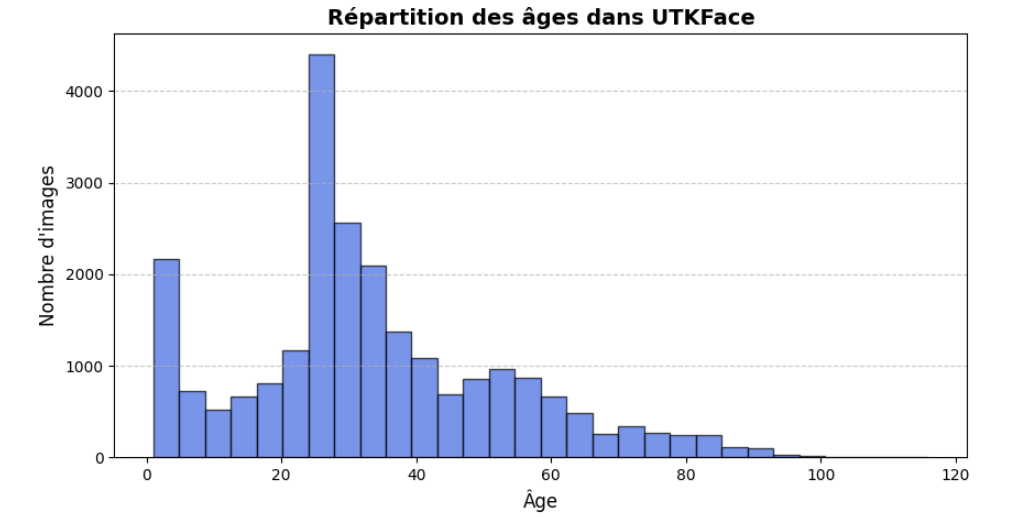


L’histogramme ci-joint met en évidence une forte concentration d’images autour des jeunes adultes (environ 20 ans), tandis que les tranches d’âge plus élevées sont nettement moins représentées. Cette distribution déséquilibrée peut influencer l’apprentissage du modèle, qui risque alors d’être moins performant pour les classes d’âge sous-représentées, notamment les personnes âgées.

Il est important de noter que les âges sont extraits à partir des noms de fichiers, ce qui peut introduire une certaine incertitude.

En effet, l’âge biologique indiqué ne reflète pas toujours l’apparence réelle : certaines personnes peuvent paraître plus jeunes ou plus âgées que leur âge réel.

Par ailleurs, il est difficile pour un modèle de distinguer précisément des âges proches, comme 30 et 32 ans, car les différences physiques sont souvent subtiles. De nombreux facteurs extérieurs, tels que l’éclairage, les expressions faciales, le maquillage ou encore la qualité de l’image, peuvent également influencer la perception de l’âge et ainsi perturber la prédiction.

Le dataset UTKFace fournit également des informations sur le genre et l’origine ethnique des individus. Si certaines tranches d’âge sont sur-représentées par un groupe démographique particulier, cela peut introduire des biais dans l’apprentissage. Le modèle risque alors d’associer certaines caractéristiques visuelles (comme la couleur de peau ou certains traits du visage) à des âges spécifiques, ce qui fausserait les prédictions.

Enfin, la faible diversité dans les tranches d’âge élevées pourrait limiter la capacité du modèle à bien généraliser sur l’ensemble de la population.


###2.2. Traitement des images

De la même manière que notre modèle CNN, nous prétraitons les images de tel sorte :

- Parcours des fichiers du dataset

- Extraction de l'âge à partir du nom de fichier (chaque image étant nommée selon le format : âge_genre_ethnie_dateNaissance.jpg)

- Lecture de l’image

- Redimensionnement des images compatible avec le modèle

- Normalisation des valeurs de pixels : les valeurs, initialement comprises entre 0 et 255, sont divisées par 255.0 afin d’être ramenées dans une plage de [0, 1]

### 2.3. Division du jeu de données


De la même manière que notre modèle CNN, nous avons :
64% d'images dans le jeu d'entrainement, 20% d'images dans le jeu de validation et 20% d'images dans le jeu de test.

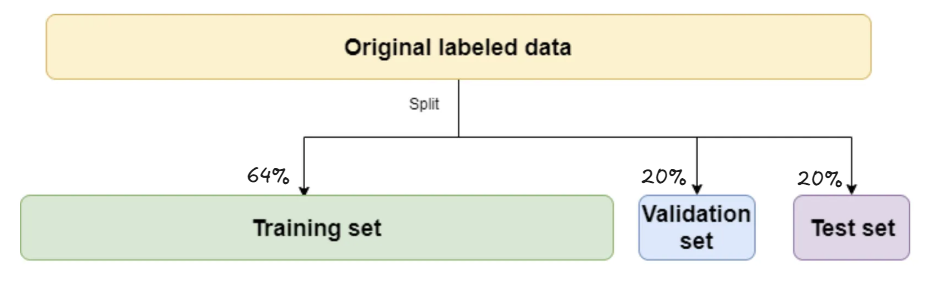

### 2.4. Implémentation et callbacks

Ce modèle de régression d’âge repose sur l'architecture ci-dessous :

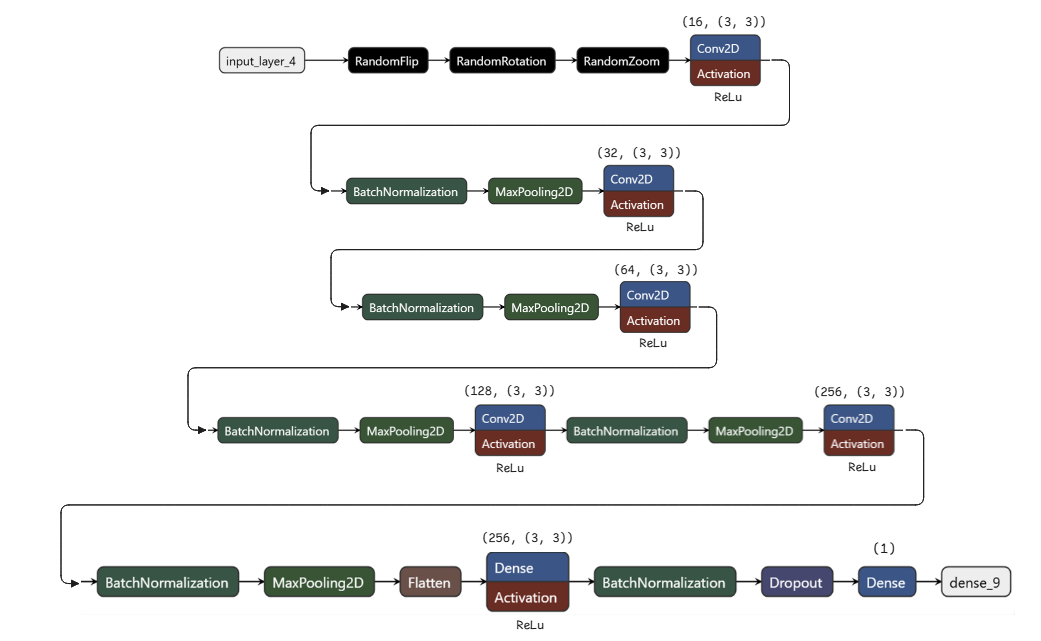


Dès l’entrée, les images subissent des transformations aléatoires (rotation, zoom etc), ce qui permet d’augmenter artificiellement la diversité des données d'entraînement.

L’architecture est composée de cinq blocs convolutionnels successifs, avec un nombre de filtres croissant : 16, 32, 64, 128 et 256 filtres respectivement. Chaque bloc est constitué d’une couche Conv2D suivie d’une normalisation par BatchNormalization, puis d’un MaxPooling2D pour réduire la dimension spatiale des cartes de caractéristiques.

Ensuite, les données sont aplaties et passent par une couche dense de 256 neurones activée par ReLU. Une régularisation est appliquée via une couche Dropout(0.4), qui désactive aléatoirement 40 % des neurones lors de l’entraînement afin de limiter le surapprentissage.

La couche de sortie contient un seul neurone, sans fonction d’activation, ce qui est adapté à une tâche de régression, où l’on cherche à prédire une valeur continue (l’âge estimé).

Le modèle est compilé avec l’optimiseur Adam (taux d’apprentissage fixé à 0.001), et utilise l’erreur absolue moyenne (MAE) comme fonction de perte et métrique d’évaluation.


Les prédictions continues du modèle sont ensuite converties en classes d’âge à l’aide de tranches d’âges définies.

Ces tranches ont été choisies de manière à regrouper les âges en catégories cohérentes :

0 à 3 ans : Nourrissons

4 à 9 ans : Jeunes enfants

10 à 19 ans : Adolescents

20 à 39 ans : Jeunes adultes (fusion des tranches 20–29 et 30–39)

40 à 59 ans : Adultes (fusion des tranches 40–49 et 50–59)

60 à 116 ans : Seniors (regroupe les personnes âgées de 60 à 116 ans)


Par la suite nous utilisons les mêmes callbacks que dans le précédent modèle pour l'entraînement :  



```python
# Callbacks: EarlyStopping + ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

history_v2 = model_v2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)
     
```



L'EarlyStopping surveille la val_loss et interrompt l'entraînement si aucune amélioration n’est observée après 7 époques consécutives.

Parallèlement, ReduceLROnPlateau réduit le taux d’apprentissage de moitié (factor=0.5) si la val_loss ne s’améliore pas après 3 époques, avec une limite fixée à 1e-5.

L'entraînement a été configuré sur 50 époques avec un batchsize de 32.



### 2.5. Visualisations et interprétation des résultats

L'entraînement de ce modèle a aboutit à ces résultats :

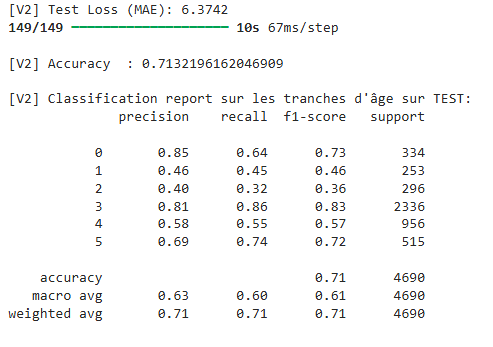

Dans le jeu de test, l’erreur moyenne de prédiction d’âge (MAE) s’établit à 6.37.

L’accuracy des tranches d’âge atteint 0.71, ce qui reste relativement correcte mais montre que le modèle a encore des difficultés à bien classer l’âge dans les bonnes catégories.

Certaines tranches d’âge s’en sortent néanmoins mieux que d’autres. Par exemple, les jeunes adultes (20–39 ans) présentent des résultats satisfaisants avec une précision de 0.81, un rappel de 0.86, et un F1-score de 0.83, indiquant que le modèle reconnaît bien les visages de cette tranche, probablement surreprésentée dans les données.

Les seniors (60–116 ans) affichent des performances plus limitées (F1-score de 0.72).

Les nourrissons (0–3 ans) obtiennent une précision élevée (0.85), ce qui montre que le modèle est déjà capable d’identifier efficacement les très jeunes visages.

En revanche, les performances sont nettement plus faibles pour les enfants (4–9 ans) et les adolescents (10–19 ans), avec des précisions autour de 0.40, signalant une difficulté du modèle à distinguer ces groupes, en raison de leur sous-représentation.

En résumé, bien que cette première version montre déjà de bonnes performances sur certaines classes, notamment les jeunes adultes et les nourrissons, elle laisse encore une large marge d’amélioration pour les tranches intermédiaires.



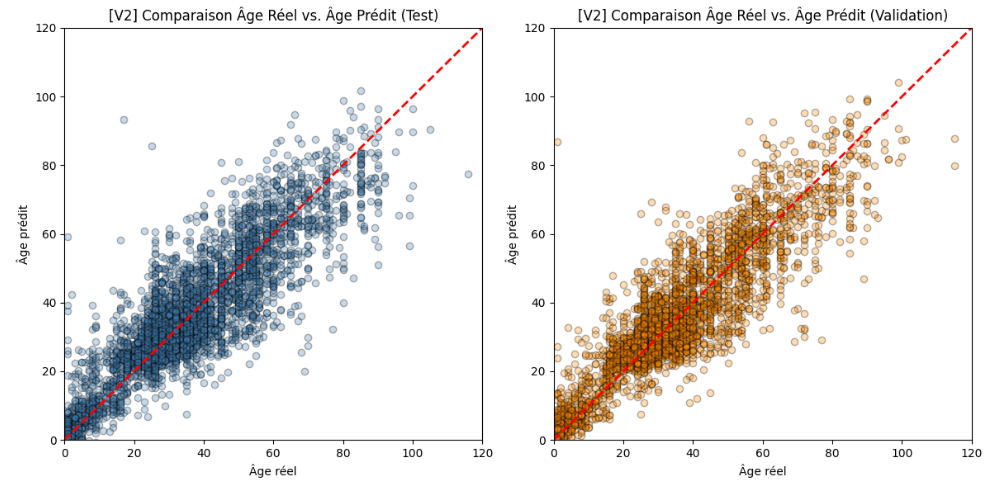

Les deux graphiques montrent une distribution des prédictions similaire entre le jeu de test et le jeu de validation, ce qui suggère que le modèle parvient à bien généraliser ses apprentissages et ne présente pas de signes évidents de surapprentissage.

Une tendance persistante se dégage toutefois : le modèle a tendance à mal classer les âges élevés. Cette faiblesse est visible dans les deux ensembles, où la majorité des points correspondant aux individus de plus de 60 ans se trouvent disersés autour de la diagonale. Cela indique que le modèle prédit des âges inférieurs ou supérieur à la réalité pour les visages les plus âgés.

En revanche, pour la tranche des 20 à 39 ans, les prédictions sont bien alignées sur la diagonale, ce qui montre que le modèle est particulièrement performant pour cette catégorie, certainement en raison d’une représentation importante de cette tranche dans les données d'entraînement.

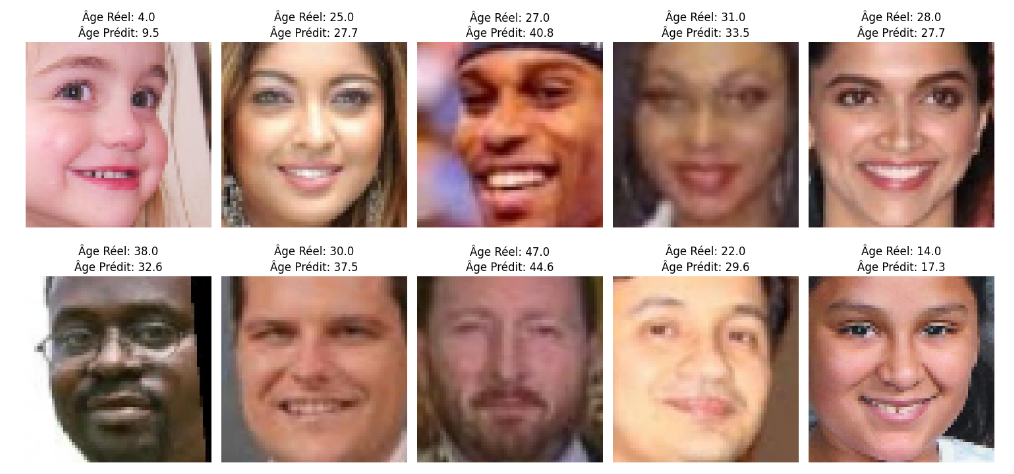

##III. Prédiction simultanée du genre et de l’age.

###3.1 Traitements des images

De la même manière que nos 2 premiers modèles, nous prétraitons les images de tel sorte :

- Parcours des fichiers du dataset

- Extraction de l'âge ET du sexe à partir du nom de fichier (chaque image étant nommée selon le format : âge_genre_ethnie_dateNaissance.jpg)

- Lecture de l’image à l’aide de bibliothèques adaptées

- Redimensionnement des images compatible avec le modèle

- Normalisation des valeurs de pixels : les valeurs, initialement comprises entre 0 et 255, sont divisées par 255.0 afin d’être ramenées dans une plage de [0, 1]

###3.2 Implémentation et callbacks

On se base sur le modèle 1 et le modèle 2 afin de créer celui-ci :

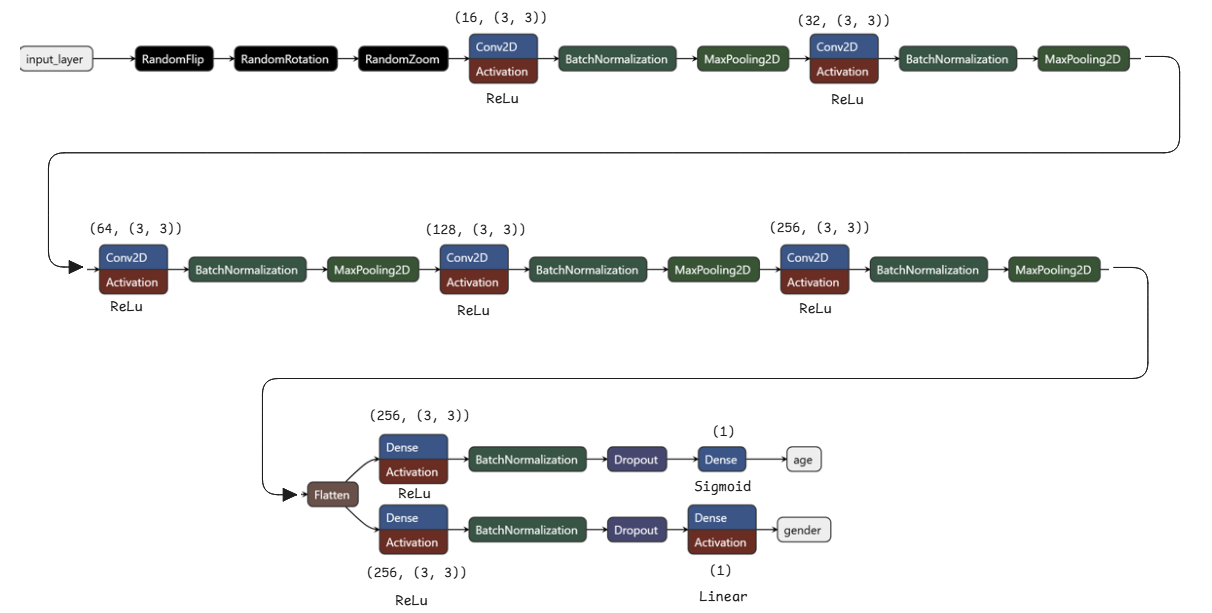

En entré, les images subissent des transformations aléatoires (renversement, rotation, zoom).

L’architecture repose sur cinq blocs convolutionnels successifs, avec un nombre de filtres croissant : 16, 32, 64, 128 et 256 filtres respectivement. Chaque bloc est composé d’une couche Conv2D activée par ReLU, suivie d’une normalisation via BatchNormalization, puis d’une opération de MaxPooling2D.

Par la suite, les données sont aplaties (Flatten) pour être transmises à deux branches distinctes : une pour la classification du genre, l’autre pour la régression de l’âge.

Dans la branche genre, les données traversent une couche dense de 256 neurones avec activation ReLU, suivie d’une normalisation par BatchNormalization et d’une régularisation via Dropout. La sortie se fait par un neurone avec une activation sigmoïde, permettant de prédire la probabilité d’appartenance à l’une des deux classes (homme/femme).

Dans la branche âge, la structure est similaire : une couche dense de 256 neurones avec ReLU, normalisée et régularisée. La sortie contient un seul neurone, sans fonction d’activation, ce qui est adapté à une tâche de régression visant à estimer une valeur continue (l’âge en années).





```python

# Callbacks: EarlyStopping + ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=6,
    min_lr=1e-5
)

history_v1 = model_v1.fit(
    X_train,
    (y_train_gender, y_train_age),
    validation_data=(X_val, (y_val_gender, y_val_age)),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)
```



De la même mannière que dans les 2 précédents modèles, les callback utilisés sont les suivants :    

 EarlyStopping, qui interrompt l’entraînement si aucune amélioration n’est constatée après 10 époques et ReduceLROnPlateau qui ajuste dynamiquement le taux d’apprentissage en le réduisant de moitié si la val_loss ne s’améliore pas sur une période de 6 époques consécutives.

  L’entraînement a été lancé cette fois-ci sur 100 époques avec un batchsize de 32.

### 3.3. Visualisations et interprétation des résultats

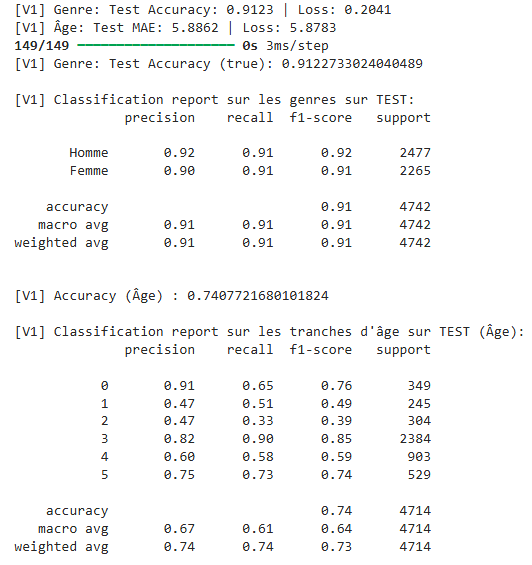

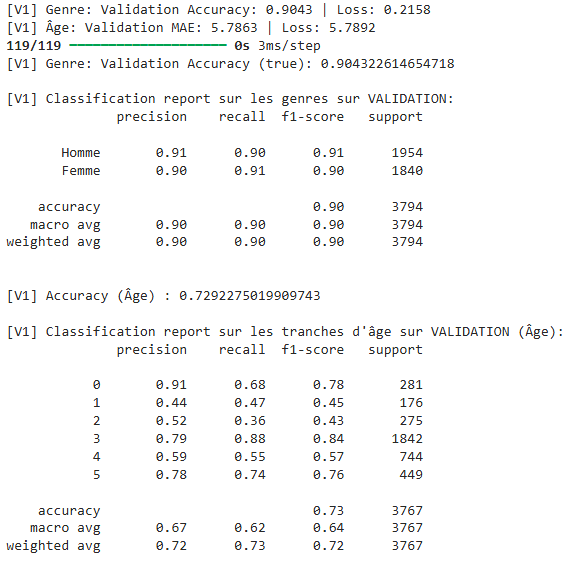

L’objectif ici est de vérifier si les améliorations observées sur le jeu de test se retrouvent également sur le jeu de validation.

Cela permet d’évaluer la stabilité du modèle ainsi que sa capacité à généraliser.

On observe que les performances du modèle sont légèrement inférieures sur le jeu de validation par rapport au jeu de test, ce qui est relativement inhabituel, étant donné que le jeu de validation intervient lors de l’entraînement. Cela suggère néanmoins une bonne capacité de généralisation du modèle, sans signe évident de surapprentissage.

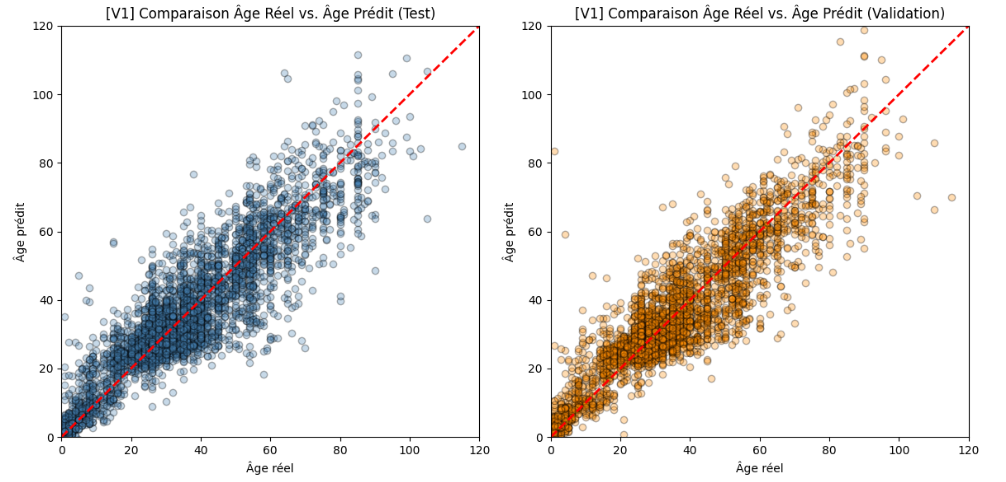

Les deux graphiques présentent une distribution similaire, ce qui suggère que le modèle généralise correctement et n’est pas sujet au surapprentissage.

On observe une tendance persistante à sous-estimer les âges élevés, visible sur les deux ensembles : la majorité des prédictions pour les individus de plus de 60 ans se situent en dessous de la diagonale, traduisant une sous-estimation systématique. Cette faiblesse était déjà présente dans les modèles et itérations précédentes.

En revanche, pour la tranche d’âge 20-39 ans, les prédictions sont bien alignées sur la diagonale, ce qui témoigne d’une bonne précision du modèle sur cette catégorie.

Le fait d’obtenir des résultats comparables à ceux du deuxième modèle est rassurant, d’autant plus que l’architecture utilisée ici en est très proche.

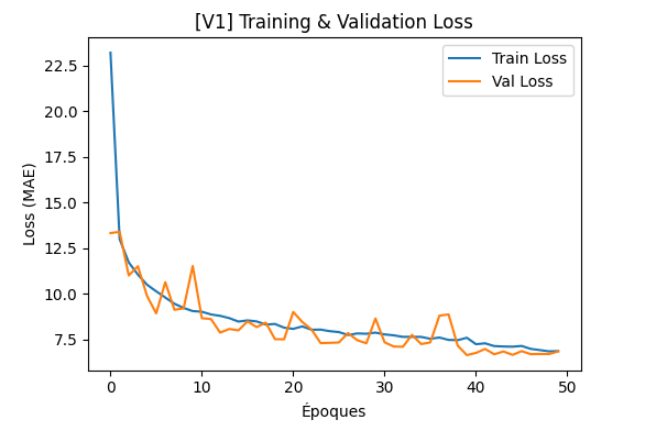

Ce graphique illustre l’évolution de la loss (MAE – Mean Absolute Error) au fil des époques pour l’entraînement et la validation du modèle.

Il permet d’évaluer la convergence du modèle, sa stabilité, ainsi que la présence éventuelle de surapprentissage.

On observe une chute rapide de la loss d’entraînement entre les premières époques (0 à 5), indiquant un apprentissage efficace. De son côté, la loss de validation diminue progressivement, avec quelques fluctuations, avant de se stabiliser autour de 6-7 MAE à partir de l’époque 40. Cette stagnation marque un début de surapprentissage, maîtrisé par l’utilisation du EarlyStopping.

La convergence est claire : le modèle atteint un plateau d’apprentissage : Grâce à la régularisation, le modèle ne montre pas de signes d’overfitting.

En conclusion, ce modèle offre de meilleures performances en prédiction de l’âge par rapport au modèle 2, tout en conservant une précision comparable au modèle 1 pour la prédiction du genre.

Ces améliorations sont notamment dues à l’augmentation de la patience des callbacks EarlyStopping et ReduceLROnPlateau, permettant au modèle de continuer à s’affiner tout en évitant le surapprentissage.

##IIII. Modèle de Prédiction d'Âge et de Genre par Transfer Learning

L’objectif ici est de former un modèle capable de prédire simultanément l’âge, une valeur continue et le genre. Pour cela, on entraîne un réseau de neurones , basé sur l’architecture EfficientNetB3, en utilisant un processus d’entraînement progressif.

###4.1. Traitement des images

De la même manière que les modèles précédents, nous redimensionnons et normalisons, cette fois-ci via la fonction preprocess_input() d'EfficientNet, qui adapte l’échelle des pixels (important pour les modèles préentraînés sur ImageNet) puisque les réseaux pré-entraînés comme EfficientNet attendent des images dans une certaine plage de valeurs (souvent entre -1 et 1 ou 0 et 1).

###4.2. Implémentation et callbacks

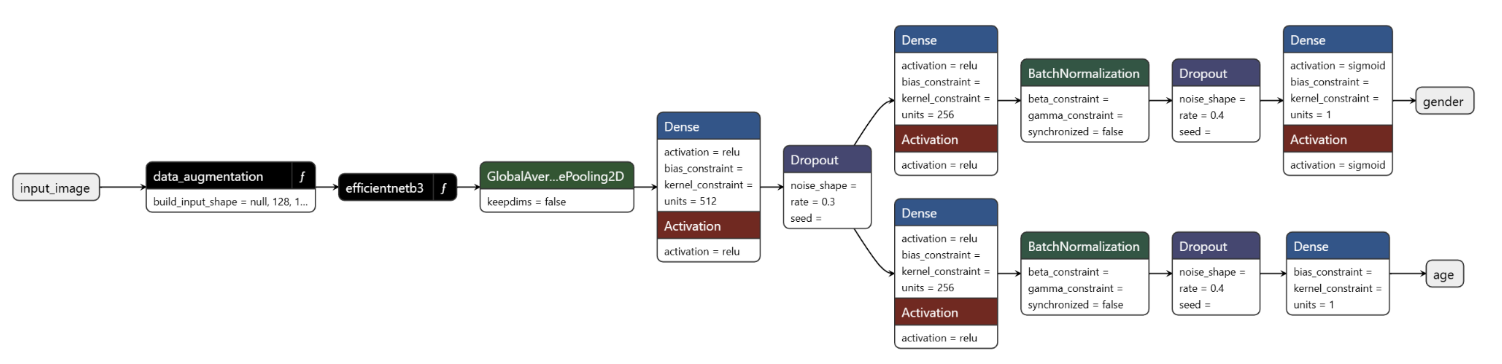

Dans un premier temps, les images passent par un bloc de data_augmentation.

L’extracteur de caractéristiques principal est le réseau EfficientNetB3, un modèle convolutionnel, composé de plusieurs blocs convolutifs.

Au début de l’entraînement, toutes les couches sont gelées, c’est-à-dire que leurs poids ne sont pas modifiés.

Par la suite, lors du fine-tuning, on déverrouille progressivement certaines couches du modèle.

Une couche Dense de 512 neurones avec activation ReLU est ajoutée pour permettre au réseau de combiner les caractéristiques extraites en représentations plus discriminantes.

Une couche de Dropout est utilisée ici pour réduire le surapprentissage, en désactivant aléatoirement certains neurones pendant l'entraînement.

Le réseau se sépare ensuite en deux branches distinctes, afin d’effectuer deux prédictions différentes en parallèle :

- Branche 1 – Prédiction de l’âge
Une couche Dense de 256 neurones (ReLU), suivie d’une BatchNormalization et d’un Dropout (0.4).

La sortie finale est une couche Dense d’un seul neurone, sans activation, adapté à une tâche de régression (prédiction d'une valeur continue).

La fonction de perte utilisée est la MAE (Mean Absolute Error), qui mesure l’erreur moyenne en années entre l’âge réel et l’âge prédit.

- Branche 2 – Prédiction du genre
Même structure que la branche âge : Dense (256), BatchNorm, Dropout (0.4)

La couche finale est une couche Dense avec activation sigmoid, produisant une probabilité entre 0 et 1, représentant le genre : 0 = Homme, 1 = Femme.

La perte utilisée ici est la Binary Crossentropy.

Par ailleures, trois callbacks ont été utilisés :
- EarlyStopping (patience de 7 époques)
- ReduceLROnPlateau (patience de 3 époques, facteur de réduction de 0.5)
- ModelCheckpoint pour sauvegarder le meilleur modèle selon la val_loss



```python
# On définit une liste de callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5),
    ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)
]

```



###4.3. Entraînement

Au départ, toutes les couches du modèle EfficientNetB3 sont gelées.

Ensuite, à travers 6 phases successives, on dégèle progressivement les couches du modèle:

- Phase 1 : 64 dernières couches dégelées

- Phase 2 : 128 dernières couches dégelées

- Phase 3 : 192 dernières couches dégelées

- Phase 4 : 256 dernières couches dégelées

- Phase 5 : 320 dernières couches dégelées

- Phase 6 : Totalité du Modèle dégelé


À chaque phase de fine-tuning, un nouveau taux d’apprentissage (learning rate) est défini. Celui-ci diminue progressivement afin de stabiliser l’entraînement.



```
    # On ajuste un learning rate (LR) exponentiellement décroissant à chaque phase
    lr = 1e-3 * (0.5 ** (phase - 1))
    print(f"Utilisation d'un learning rate de {lr} pour la phase {phase}")

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)

```



### 4.4. Visualisations et interprétation des résultats

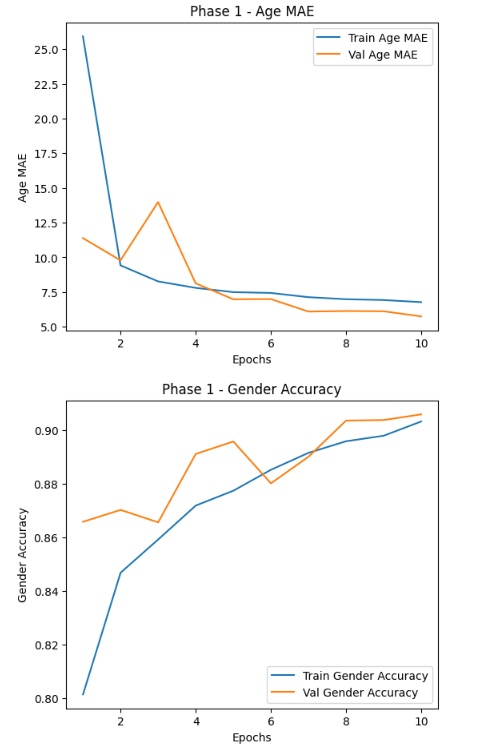

Lors de cette première phase, seules les 64 dernières couches du modèle EfficientNetB3 ont été dégelées.

Les résultats montrent une amélioration des performances, aussi bien sur l'ensemble d'entraînement que sur les données de validation. L'erreur absolue moyenne (MAE) pour l'âge chute rapidement dès les premières époques, atteignant environ 5.5 sur le jeu de validation.

En parallèle, la précision de prédiction du genre grimpe progressivement pour atteindre 91 % sur la validation.

À ce stade, le modèle commence à bien généraliser sans signe apparent de surapprentissage, ce qui confirme la pertinence de cette première étape de fine-tuning.

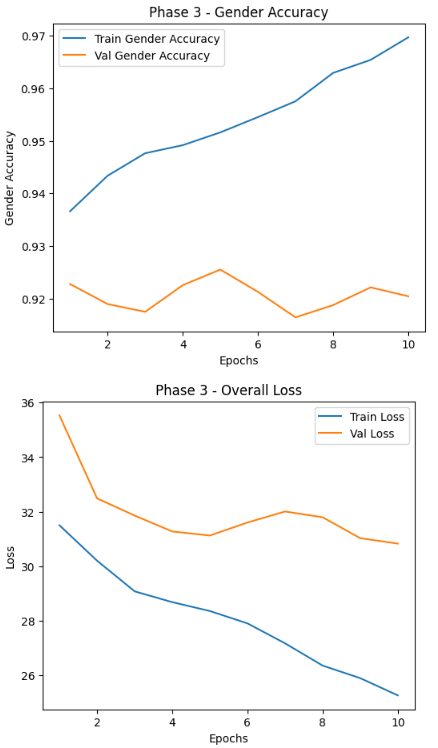

Au cours de la phase 3, 192 couches ont été dégelées.

On constate une progression de la précision sur la classification du genre dans les données d'entraînement, atteignant près de 97 %.   

Le suivi de la loss globale confirme cette tendance : bien que la perte d'entraînement diminue de manière continue, la perte sur le jeu de validation stagne et oscille légèrement. Ce comportement marque les premiers signes de surapprentissage : le modèle s'améliore encore sur les données vues, mais ne progresse plus sur les données non vues.


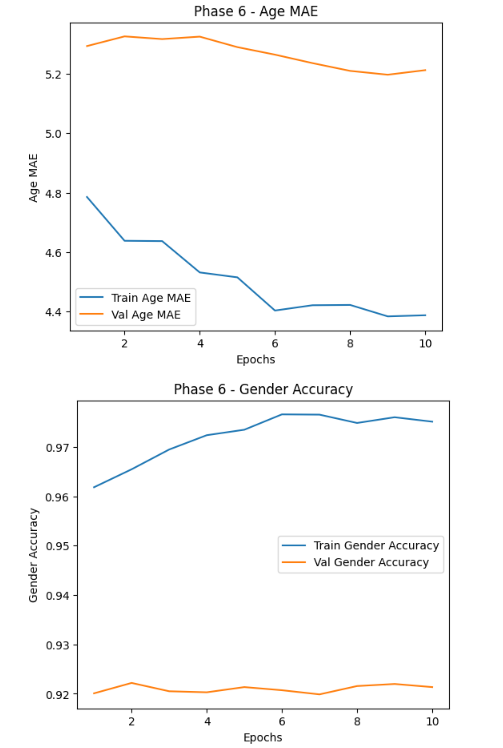

Pour cette phase finale, nous dégelons complètement l’architecture EfficientNetB3.

Ce réglage se traduit par une baisse continue de l’erreur sur la prédiction de l’âge et une précision de plus de 97 % pour la prédiction du genre sur les données d'entraînement.


Pour conclure, en débutant par un dégel partiel des couches les plus hautes, puis en étendant progressivement cette ouverture vers les couches plus profondes, nous avons pu guider l’optimisation du réseau tout en maintenant une certaine stabilité des performances.


Cette approche progressive illustre l’intérêt d’adapter progressivement l'entraînement pour en exploiter tout le potentiel.

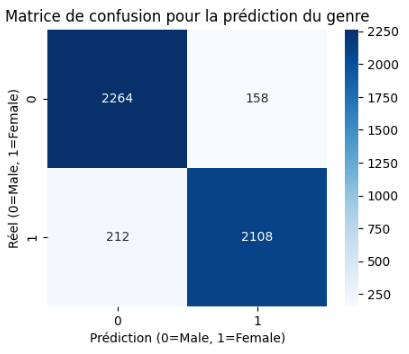

La matrice de confusion ci-dessus illustre les performances du modèle pour la tâche de classification binaire du genre (0 = Homme, 1 = Femme). Elle permet de visualiser de manière précise la répartition des prédictions correctes et erronées effectuées par le modèle sur le jeu de test.

Le modèle a correctement classé 2264 individus de genre masculin (0) et 2108 individus de genre féminin (1).

Il a toutefois commis 158 erreurs en classant à tort des hommes comme femmes, et 212 erreurs en classant des femmes comme hommes.

Ces résultats témoignent d’un équilibre satisfaisant entre les deux classes, avec des taux d’erreurs relativement proches. Le modèle ne montre pas de biais évident en faveur de l’une des deux classes.

Au total, cela représente une précision globale élevée, cohérente avec les métriques observées précédemment (~92 % sur la validation).



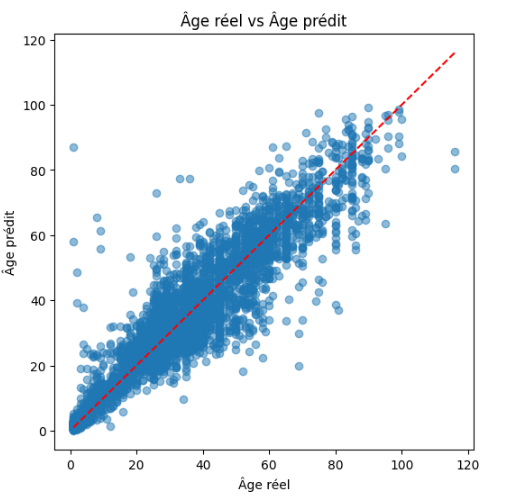

Ce graphique présente un nuage de points comparant l’âge réel à l’âge prédit. La ligne rouge en pointillés représente l'âge prédit = âge réel. En d'autre termes, la prédiction parfaite.

On observe que la majorité des points se concentrent autour de cette diagonale, indiquant que le modèle effectue des prédictions globalement cohérentes avec les âges réels.

Les écarts les plus marqués apparaissent surtout dans les tranches d’âge plus élevées (au-delà de 60 ans), où les prédictions ont tendance à être légèrement sous-estimées. Cependant, on remarque une grande amélioration des résultats par rapport aux modèles précédents. (ici  5,2209 de MAE)

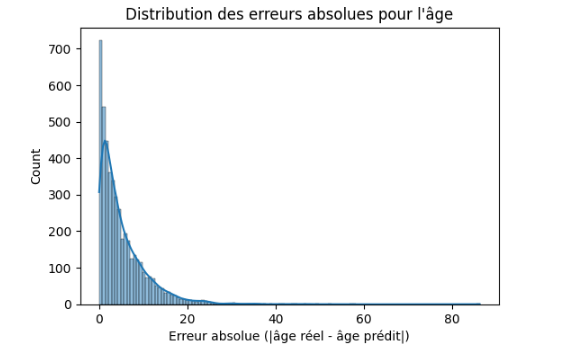

Ce graphique montre la distribution des erreurs absolues entre l’âge réel et l’âge prédit.

La distribution est très asymétrique, avec un pic net dans les petites erreurs : la majorité des prédictions présentent une erreur absolue inférieure à 10 ans, et plus de 700 cas ont une erreur inférieure à 2 ans.

Cette concentration autour de faibles écarts confirme que le modèle est capable d’estimer l’âge avec une précision satisfaisante dans la plupart des cas. Les erreurs plus importantes, bien que présentes, restent marginales et concernent une minorité d’exemples.

##Conclusion

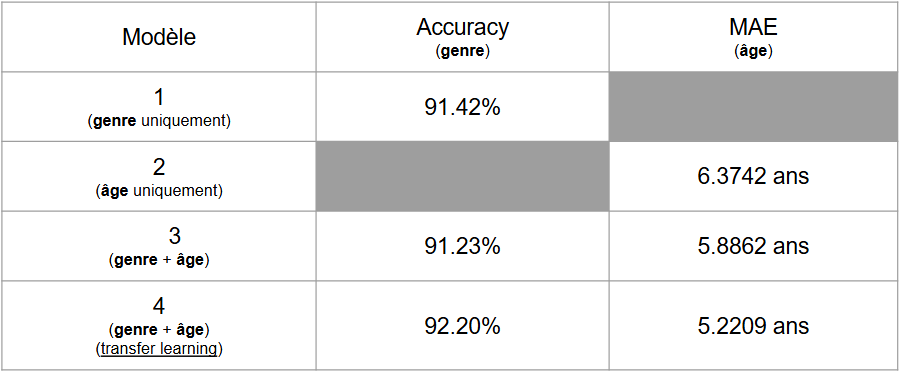

Le tableaui ci-dessous, compare les performances des différents modèles utlisés.

Le modèle 1, entraîné uniquement sur la classification du genre, atteint une précision de 91.42 %, ce qui représente une performance de solide.

De son côté, le modèle 2, dédié à la régression de l’âge, obtient un MAE de 6.3742 ans, base fiable pour les prédictions d’âge.

Le modèle 3 combine les deux tâches. Il atteint une accuracy de 91.23 % pour le genre et un MAE de 5.8862 ans pour l’âge.

Enfin, le modèle 4, basé sur une approche complète de transfer learning, se distingue nettement avec les meilleures performances globales : 92.20 % de précision pour le genre et un MAE réduit à 5.2209 ans pour l’âge.

Ce projet nous a permis d'explorer et de comparer plusieurs approches d'apprentissage  pour la prédiction de l'âge et du genre à partir d'images.

Nous avons commencé par entraîner des réseaux de neurones convolutifs (CNN) simples, d'abord pour prédire le genre uniquement, puis l'âge uniquement.

Par la suite, nous avons combiné les deux tâches au sein d’un modèle multi-sorties, capable de prédire simultanément l’âge et le genre.

Enfin, nous avons mis en œuvre une approche plus avancée via le transfer learning, en utilisant un modèle pré-entraîné (EfficientNetB3) que nous avons affiné progressivement.

Cela nous a permis de mieux comprendre l’impact de chaque méthode sur la performance globale des modèles.

